# Import all necessary Libraries

In [3]:
%matplotlib inline
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dask.dataframe as dd
from scipy.stats import skew
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler

# Oversampling

In [ ]:
NYPD_Smalldf.head(2)

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,RPT_DT,OFNS_DESC,PD_DESC,CRM_ATPT_CPTD_CD,LAW_CAT_CD,BORO_NM,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,JURIS_DESC,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,PATROL_BORO,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,Month_Abbr,Year,ADDR_PCT_CD,KY_CD,PD_CD,JURISDICTION_CODE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude
89112,50503205,2008-08-24,14:15:00,08/24/2008,DANGEROUS WEAPONS,WEAPONS POSSESSION 3,COMPLETED,FELONY,BRONX,FRONT OF,STREET,N.Y. POLICE DEPT,UNKOWN,UNKOWN,UNKOWN,PATROL BORO BRONX,UNKOWN,UNKNOWN,E,Aug,2008,44.0,118.0,793.0,0.0,1007885.0,246405.0,6.889746e+12,-0.16099
144118,49572859,2008-07-31,16:45:00,07/31/2008,HARRASSMENT 2,"HARASSMENT,SUBD 1,CIVILIAN",COMPLETED,VIOLATION,QUEENS,INSIDE,COMMERCIAL BUILDING,N.Y. POLICE DEPT,UNKOWN,BLACK,F,PATROL BORO QUEENS SOUTH,45-64,WHITE,F,Jul,2008,103.0,578.0,637.0,0.0,1039788.0,196518.0,6.700471e+12,-0.16099


# Load DataSet

In [ ]:
!gdown --fuzzy https://drive.google.com/file/d/1iuhrtVJIhJ4xPlrNmUL570gBUoozB3YJ/view?usp=sharing

Downloading...
From: https://drive.google.com/uc?id=1iuhrtVJIhJ4xPlrNmUL570gBUoozB3YJ
To: /content/NYPD_cleaned_data.csv
100% 11.2M/11.2M [00:00<00:00, 39.6MB/s]


In [ ]:
NYPD_Smalldf = pd.read_csv('NYPD_cleaned_data.csv', low_memory=False, index_col = 0)
NYPD_Smalldf = NYPD_Smalldf[(NYPD_Smalldf['BORO_NM'] != 'UNKOWN') & (NYPD_Smalldf['LOC_OF_OCCUR_DESC'] != 'UNKOWN')]

# Additional Columns

In [ ]:

NYPD_Smalldf['RPT_DT'] = pd.to_datetime(NYPD_Smalldf['RPT_DT'])

NYPD_Smalldf['RPT_YEAR'] = NYPD_Smalldf['RPT_DT'].dt.year
NYPD_Smalldf['RPT_MONTH'] = NYPD_Smalldf['RPT_DT'].dt.month
NYPD_Smalldf['RPT_DAY'] = NYPD_Smalldf['RPT_DT'].dt.day
NYPD_Smalldf['RPT_DAY_OF_WEEK'] = NYPD_Smalldf['RPT_DT'].dt.dayofweek
NYPD_Smalldf['RPT_IS_WEEKEND'] = NYPD_Smalldf['RPT_DAY_OF_WEEK'].isin([5, 6]).astype(int)


In [ ]:
NYPD_Smalldf['CMPLNT_FR_DT'] = pd.to_datetime(NYPD_Smalldf['CMPLNT_FR_DT'])
NYPD_Smalldf['REPORT_DELAY'] = (NYPD_Smalldf['RPT_DT'] - NYPD_Smalldf['CMPLNT_FR_DT']).dt.days
NYPD_Smalldf['REPORT_DELAY'] = NYPD_Smalldf['REPORT_DELAY'].fillna(0).clip(lower=0)


In [ ]:
def time_of_day(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 24:
        return 'Evening'
    else:
        return 'Night'

NYPD_Smalldf['CMPLNT_FR_TM'] = pd.to_datetime(NYPD_Smalldf['CMPLNT_FR_TM'])
NYPD_Smalldf['Hour'] = NYPD_Smalldf['CMPLNT_FR_TM'].dt.hour
NYPD_Smalldf['Time_Category'] = NYPD_Smalldf['Hour'].apply(time_of_day)

<ipython-input-8-ca0f05bdae02>:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  NYPD_Smalldf['CMPLNT_FR_TM'] = pd.to_datetime(NYPD_Smalldf['CMPLNT_FR_TM'])


# Data loading

# Logistic Regression

Mean cross-validation accuracy: 0.5225180744136837

Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.27      0.33      1132
           1       0.57      0.73      0.64      2008
           2       0.33      0.20      0.25       547

    accuracy                           0.51      3687
   macro avg       0.43      0.40      0.40      3687
weighted avg       0.48      0.51      0.48      3687

Confusion Matrix:
 [[ 310  755   67]
 [ 393 1457  158]
 [  72  363  112]]


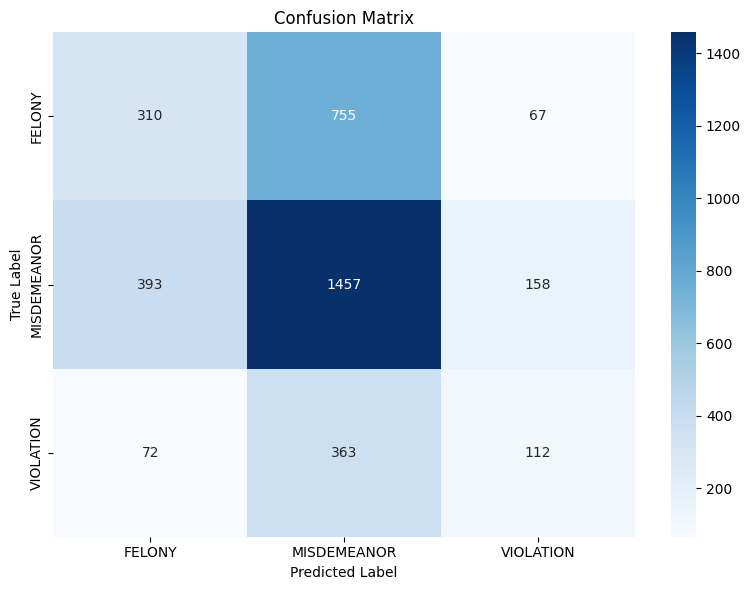

In [ ]:
'''
steps
1. Import clean datasets
2. Encoding the categorical columns to numbers
3. Data preprocessing for numerical columns using standard Scaler
4. Concatenated the new variables
5. Split Data into train and test
6. Define Regression Model
6. Plot the confusion Matrix
'''

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(NYPD_Smalldf['LAW_CAT_CD'])

X = NYPD_Smalldf[['CRM_ATPT_CPTD_CD', 'ADDR_PCT_CD','LOC_OF_OCCUR_DESC','BORO_NM','SUSP_RACE','SUSP_SEX',
                  'SUSP_AGE_GROUP','PREM_TYP_DESC','Y_COORD_CD','Longitude','Month_Abbr','CMPLNT_FR_DT']]

categorical_cols = ['CRM_ATPT_CPTD_CD', 'LOC_OF_OCCUR_DESC', 'BORO_NM', 'SUSP_RACE', 'SUSP_SEX',
                    'SUSP_AGE_GROUP', 'PREM_TYP_DESC', 'Month_Abbr', 'CMPLNT_FR_DT']

numeric_cols = ['ADDR_PCT_CD', 'Longitude', 'Y_COORD_CD']


# pipeline preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numeric_cols)
    ],
    remainder='passthrough'
)


# model pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='lbfgs', max_iter=1000))
])

cv_accuracy = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy').mean()
print("Mean cross-validation accuracy:", cv_accuracy)



# train test
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.13, random_state=42, stratify = y, )
pipeline.fit(x_train, y_train)
y_pred = pipeline.predict(x_test)


print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
class_labels = label_encoder.classes_
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

In [ ]:
NYPD_Smalldf.to_csv("NYPD_cleaned_data_smalldf.csv", index=False)

In [ ]:
NYPD_Smalldf.head()
#NYPD_Smalldf.columns

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,RPT_DT,OFNS_DESC,PD_DESC,CRM_ATPT_CPTD_CD,LAW_CAT_CD,BORO_NM,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,JURIS_DESC,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,PATROL_BORO,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,Month_Abbr,Year,ADDR_PCT_CD,KY_CD,PD_CD,JURISDICTION_CODE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,RPT_YEAR,RPT_MONTH,RPT_DAY,RPT_DAY_OF_WEEK,RPT_IS_WEEKEND,REPORT_DELAY,Hour,Time_Category
89112,50503205,2008-08-24,2025-04-06 14:15:00,2008-08-24,DANGEROUS WEAPONS,WEAPONS POSSESSION 3,COMPLETED,FELONY,BRONX,FRONT OF,STREET,N.Y. POLICE DEPT,UNKOWN,UNKOWN,UNKOWN,PATROL BORO BRONX,UNKOWN,UNKNOWN,E,Aug,2008,44.0,118.0,793.0,0.0,1007885.0,246405.0,6.889746e+12,-0.16099,2008,8,24,6,1,0,14,Afternoon
144118,49572859,2008-07-31,2025-04-06 16:45:00,2008-07-31,HARRASSMENT 2,"HARASSMENT,SUBD 1,CIVILIAN",COMPLETED,VIOLATION,QUEENS,INSIDE,COMMERCIAL BUILDING,N.Y. POLICE DEPT,UNKOWN,BLACK,F,PATROL BORO QUEENS SOUTH,45-64,WHITE,F,Jul,2008,103.0,578.0,637.0,0.0,1039788.0,196518.0,6.700471e+12,-0.16099,2008,7,31,3,0,0,16,Afternoon
1246,54668019,2008-12-03,2025-04-06 17:00:00,2008-12-04,OFF. AGNST PUB ORD SENSBLTY &,AGGRAVATED HARASSMENT 2,COMPLETED,MISDEMEANOR,BROOKLYN,INSIDE,OTHER,N.Y. POLICE DEPT,25-44,BLACK,M,PATROL BORO BKLYN SOUTH,UNKOWN,UNKNOWN,D,Dec,2008,67.0,361.0,639.0,0.0,1004972.0,178862.0,6.634861e+12,-0.16099,2008,12,4,3,0,1,17,Afternoon
81806,52249900,2008-10-12,2025-04-06 14:00:00,2008-10-15,HARRASSMENT 2,"HARASSMENT,SUBD 1,CIVILIAN",COMPLETED,VIOLATION,BROOKLYN,INSIDE,RESIDENCE - APT. HOUSE,N.Y. POLICE DEPT,UNKOWN,BLACK,F,PATROL BORO BKLYN NORTH,45-64,BLACK,M,Oct,2008,75.0,578.0,637.0,0.0,1019138.0,182827.0,6.649530e+12,-0.16099,2008,10,15,2,0,3,14,Afternoon
7752,44399394,2006-01-13,2025-04-06 16:00:00,2008-03-08,SEX CRIMES,SODOMY 1,COMPLETED,FELONY,BRONX,FRONT OF,RESIDENCE-HOUSE,N.Y. POLICE DEPT,18-24,WHITE HISPANIC,M,PATROL BORO BRONX,<18,WHITE HISPANIC,F,Jan,2006,42.0,116.0,168.0,0.0,1008690.0,238862.0,6.860865e+12,-0.16099,2008,3,8,5,1,785,16,Afternoon


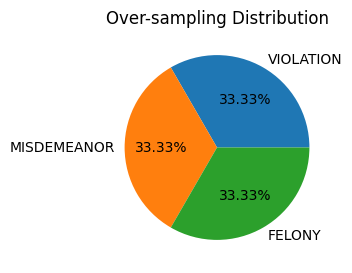

Mean cross-validation accuracy: 0.5599167845433428

Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.83      0.68      3089
           1       0.56      0.34      0.43      3089
           2       0.53      0.52      0.53      3089

    accuracy                           0.56      9267
   macro avg       0.56      0.56      0.55      9267
weighted avg       0.56      0.56      0.55      9267

Confusion Matrix:
 [[2552  186  351]
 [ 980 1063 1046]
 [ 858  633 1598]]


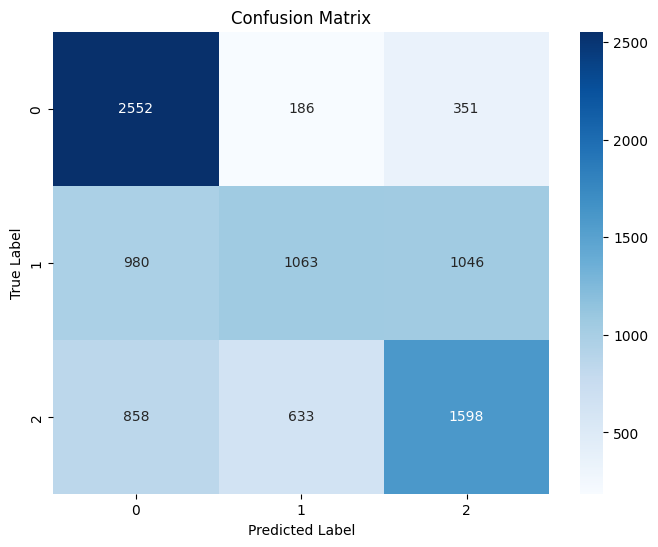

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler

X = NYPD_Smalldf[['CRM_ATPT_CPTD_CD', 'ADDR_PCT_CD','LOC_OF_OCCUR_DESC','BORO_NM','SUSP_RACE','SUSP_SEX',
                  'SUSP_AGE_GROUP','PREM_TYP_DESC','Y_COORD_CD','Longitude','Month_Abbr','REPORT_DELAY','RPT_DAY','RPT_IS_WEEKEND','Time_Category']]


severity_order = {'VIOLATION': 0, 'MISDEMEANOR': 1, 'FELONY': 2}
y_ord = NYPD_Smalldf['LAW_CAT_CD'].map(severity_order)



rus = RandomOverSampler(sampling_strategy="not majority", random_state=42)
X_res, y_res = rus.fit_resample(X, y_ord)


unique_labels_encoded, counts = np.unique(y_res, return_counts=True)
original_labels = [key for key, value in severity_order.items()]

plt.figure(figsize=(3, 3))
plt.pie(counts, labels=original_labels, autopct='%.2f%%')
plt.title("Over-sampling Distribution")
plt.show()


categorical_cols = ['CRM_ATPT_CPTD_CD', 'LOC_OF_OCCUR_DESC', 'BORO_NM', 'SUSP_RACE', 'SUSP_SEX',
                    'SUSP_AGE_GROUP', 'PREM_TYP_DESC', 'Month_Abbr','Time_Category']

numeric_cols = ['ADDR_PCT_CD', 'Longitude', 'Y_COORD_CD','REPORT_DELAY','RPT_DAY','RPT_IS_WEEKEND']



# pipeline preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numeric_cols)
    ],
    remainder='passthrough'
)



#Model pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='lbfgs', max_iter=1000,class_weight='balanced'))
])


# train test
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res,
    test_size=0.20,
    random_state=42,
    stratify=y_res,
)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)


cv_accuracy = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy').mean()
print("Mean cross-validation accuracy:", cv_accuracy)


print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig("LogisticRegression_confusion_matrix.png")



# XGBOOST

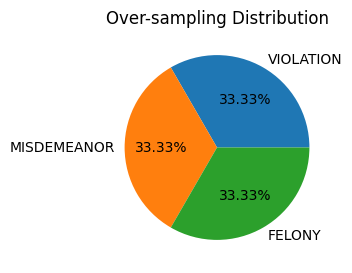

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:48:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:48:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:49:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:49:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning

Mean cross-validation accuracy: 0.6216146140659216

Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.90      0.75      3089
           1       0.63      0.44      0.52      3089
           2       0.63      0.56      0.60      3089

    accuracy                           0.63      9267
   macro avg       0.63      0.63      0.62      9267
weighted avg       0.63      0.63      0.62      9267

Confusion Matrix:
 [[2783  136  170]
 [ 892 1356  841]
 [ 694  652 1743]]


<Figure size 640x480 with 0 Axes>

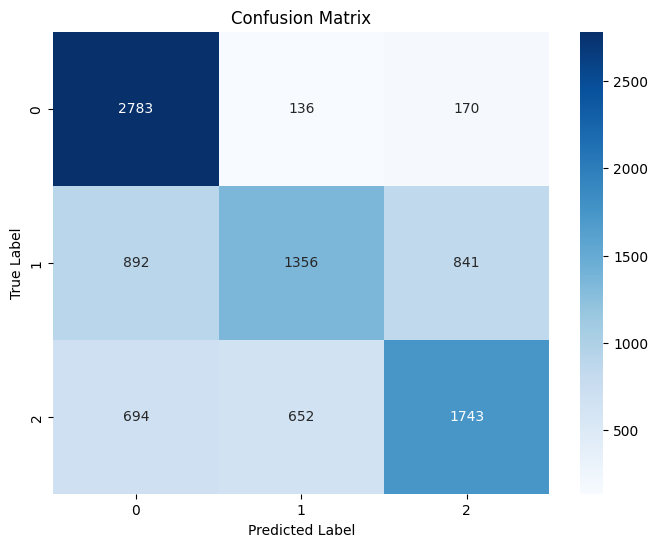

<Figure size 640x480 with 0 Axes>

In [ ]:
'''
This code is focused on classifying the severity of crimes in the NYPD dataset. It performs data preprocessing,
applies oversampling to handle class imbalance, trains an XGBoost classifier, evaluates the model using cross-validation,
and generates a classification report and confusion matrix to assess the model's performance.
'''


X = NYPD_Smalldf[['CRM_ATPT_CPTD_CD', 'ADDR_PCT_CD', 'LOC_OF_OCCUR_DESC', 'BORO_NM', 'SUSP_RACE', 'SUSP_SEX',
                  'SUSP_AGE_GROUP', 'PREM_TYP_DESC', 'Y_COORD_CD', 'Longitude', 'Month_Abbr', 'REPORT_DELAY',
                  'RPT_DAY', 'RPT_IS_WEEKEND', 'Time_Category']]

severity_order = {'VIOLATION': 0, 'MISDEMEANOR': 1, 'FELONY': 2}
y = NYPD_Smalldf['LAW_CAT_CD'].map(severity_order)


rus = RandomOverSampler(sampling_strategy="not majority", random_state=42)
X_res, y_res = rus.fit_resample(X, y)


unique_labels, counts = np.unique(y_res, return_counts=True)
original_labels = [key for key, value in severity_order.items()]
plt.figure(figsize=(3, 3))
plt.pie(counts, labels=original_labels, autopct='%.2f%%')
plt.title("Over-sampling Distribution")
plt.show()
plt.savefig("Over-sampling_Distribution.png")


categorical_cols = ['CRM_ATPT_CPTD_CD', 'LOC_OF_OCCUR_DESC', 'BORO_NM', 'SUSP_RACE', 'SUSP_SEX', 'SUSP_AGE_GROUP',
                    'PREM_TYP_DESC', 'Month_Abbr', 'Time_Category']
numeric_cols = ['ADDR_PCT_CD', 'Longitude', 'Y_COORD_CD', 'REPORT_DELAY', 'RPT_DAY', 'RPT_IS_WEEKEND']


# pipline preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numeric_cols)
    ]
)

# ml pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(eval_metric='mlogloss', use_label_encoder=False, scale_pos_weight=1))
])


X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.20, random_state=42, stratify=y_res)


pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)


cv_accuracy = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy').mean()
print("Mean cross-validation accuracy:", cv_accuracy)


print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig("XGBOOST_confusion_matrix.png")


# Random Forest Classifier

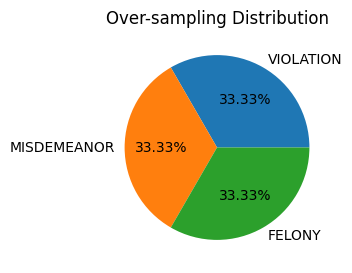

Mean cross-validation accuracy: 0.7539928015260268

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.99      0.90      3089
           1       0.79      0.62      0.70      3089
           2       0.79      0.79      0.79      3089

    accuracy                           0.80      9267
   macro avg       0.80      0.80      0.79      9267
weighted avg       0.80      0.80      0.79      9267

Confusion Matrix:
 [[3058   24    7]
 [ 513 1927  649]
 [ 158  493 2438]]


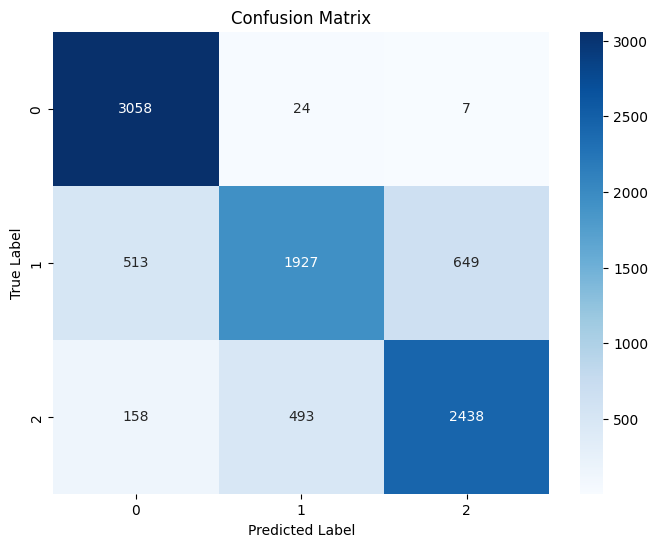

<Figure size 640x480 with 0 Axes>

In [ ]:
'''
This code is focused on classifying the severity of crimes in the NYPD dataset.This code performs data preprocessing,
applies oversampling to handle class imbalance, trains a Random Forest classifier,
evaluates the model with cross-validation, and generates a classification report and confusion matrix for performance assessment.
'''

X = NYPD_Smalldf[['CRM_ATPT_CPTD_CD', 'ADDR_PCT_CD','LOC_OF_OCCUR_DESC','BORO_NM','SUSP_RACE','SUSP_SEX',
                  'SUSP_AGE_GROUP','PREM_TYP_DESC','Y_COORD_CD','Longitude','Month_Abbr','REPORT_DELAY','RPT_DAY','RPT_IS_WEEKEND','Time_Category']]


severity_order = {'VIOLATION': 0, 'MISDEMEANOR': 1, 'FELONY': 2}
y_ord = NYPD_Smalldf['LAW_CAT_CD'].map(severity_order)


rus = RandomOverSampler(sampling_strategy="not majority", random_state=42)
X_res, y_res = rus.fit_resample(X, y_ord)


unique_labels_encoded, counts = np.unique(y_res, return_counts=True)
original_labels = [key for key, value in severity_order.items()]
plt.figure(figsize=(3, 3))
plt.pie(counts, labels=original_labels, autopct='%.2f%%')
plt.title("Over-sampling Distribution")
plt.show()


categorical_cols = ['CRM_ATPT_CPTD_CD', 'LOC_OF_OCCUR_DESC', 'BORO_NM', 'SUSP_RACE', 'SUSP_SEX',
                    'SUSP_AGE_GROUP', 'PREM_TYP_DESC', 'Month_Abbr','Time_Category']

numeric_cols = ['ADDR_PCT_CD', 'Longitude', 'Y_COORD_CD','REPORT_DELAY','RPT_DAY','RPT_IS_WEEKEND']



preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numeric_cols)
    ],
    remainder='passthrough'
)




pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])




X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res,
    test_size=0.20,
    random_state=42,
    stratify=y_res,
)


pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)


cv_accuracy = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy').mean()
print("Mean cross-validation accuracy:", cv_accuracy)


print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig("RandomForest_confusion_matrix.png")


# Support Vector Machine

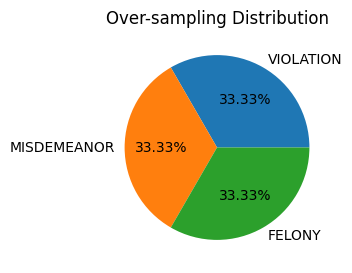

Mean cross-validation accuracy: 0.5844664796287597

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.88      0.71      3089
           1       0.59      0.41      0.48      3089
           2       0.59      0.50      0.54      3089

    accuracy                           0.60      9267
   macro avg       0.60      0.60      0.58      9267
weighted avg       0.60      0.60      0.58      9267

Confusion Matrix:
 [[2726  137  226]
 [1004 1260  825]
 [ 822  727 1540]]


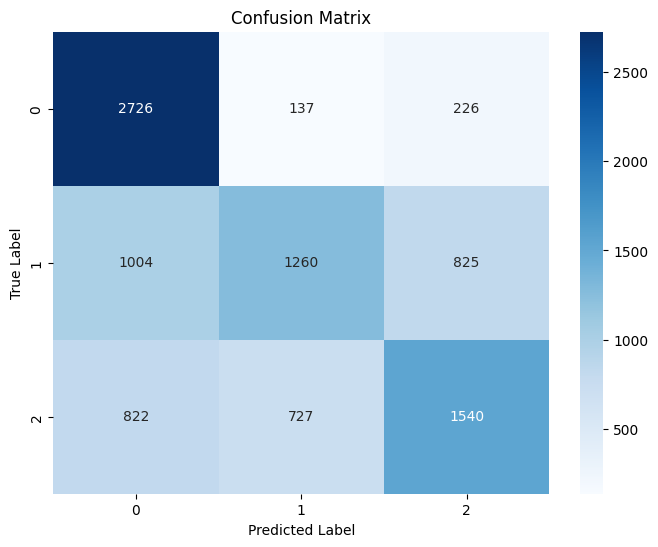

In [ ]:
'''
This code is focused on classifying the severity of crimes in the NYPD dataset.
It performs data preprocessing, applies oversampling to address class imbalance,
trains an SVM classifier using a pipeline with OneHotEncoding and StandardScaler,
evaluates the model using cross-validation, and visualizes the classification
results with a confusion matrix.
'''


X = NYPD_Smalldf[['CRM_ATPT_CPTD_CD', 'ADDR_PCT_CD','LOC_OF_OCCUR_DESC','BORO_NM','SUSP_RACE','SUSP_SEX',
                  'SUSP_AGE_GROUP','PREM_TYP_DESC','Y_COORD_CD','Longitude','Month_Abbr','REPORT_DELAY','RPT_DAY','RPT_IS_WEEKEND','Time_Category']]

severity_order = {'VIOLATION': 0, 'MISDEMEANOR': 1, 'FELONY': 2}
y_ord = NYPD_Smalldf['LAW_CAT_CD'].map(severity_order)




rus = RandomOverSampler(sampling_strategy="not majority", random_state=42)
X_res, y_res = rus.fit_resample(X, y_ord)




unique_labels_encoded, counts = np.unique(y_res, return_counts=True)
original_labels = [key for key, value in severity_order.items()]

plt.figure(figsize=(3, 3))
plt.pie(counts, labels=original_labels, autopct='%.2f%%')
plt.title("Over-sampling Distribution")
plt.show()




categorical_cols = ['CRM_ATPT_CPTD_CD', 'LOC_OF_OCCUR_DESC', 'BORO_NM', 'SUSP_RACE', 'SUSP_SEX',
                    'SUSP_AGE_GROUP', 'PREM_TYP_DESC', 'Month_Abbr','Time_Category']

numeric_cols = ['ADDR_PCT_CD', 'Longitude', 'Y_COORD_CD','REPORT_DELAY','RPT_DAY','RPT_IS_WEEKEND']



preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numeric_cols) ],remainder='passthrough')

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(class_weight='balanced', kernel='rbf', C=1))
])


X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res,
    test_size=0.20,
    random_state=42,
    stratify=y_res,
)


pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

cv_accuracy = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy').mean()
print("Mean cross-validation accuracy:", cv_accuracy)



print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix Support Vector Machine')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig("SVM_confusion_matrix.png")
